In [275]:
import numpy as np
import  pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import warnings
warnings.filterwarnings('ignore')

plt.style.use("seaborn-whitegrid")
plt.rcParams["font.size"] = 14

In [276]:
# Use for all the same features
data = pd.read_csv("df.csv")
data2 = pd.read_csv("Cleaned_2015.csv")
data3 = pd.read_csv("Cleaned_2016.csv")
data4 = pd.read_csv("Cleaned_2017.csv")
data5= pd.read_csv("Cleaned_2018.csv")


#data_price = data.loc[:, ["2015 PRICE VAR [%]"]]
data_price2 = data2.loc[:, ["2016 PRICE VAR [%]"]]
data_price3 = data3.loc[:, ["2017 PRICE VAR [%]"]]
data_price4 = data4.loc[:, ["2018 PRICE VAR [%]"]]
data_price5 = data5.loc[:, ["2019 PRICE VAR [%]"]]

a = []
for i in list(data):
  if i in list(data2) and i in list(data3) and i in list(data4) and i in list(data5):
      a.append(i)

"""data = data[list(a[1:])].join(data_price).rename(columns={"2015 PRICE VAR [%]":"PRICE VAR [%]"})
data2 = data2[list(a[1:])].join(data_price2).rename(columns={"2016 PRICE VAR [%]":"PRICE VAR [%]"})
data3 = data3[list(a[1:])].join(data_price3).rename(columns={"2017 PRICE VAR [%]":"PRICE VAR [%]"})
data4 = data4[list(a[1:])].join(data_price4).rename(columns={"2018 PRICE VAR [%]":"PRICE VAR [%]"})
data5 = data5[list(a[1:])].join(data_price5).rename(columns={"2019 PRICE VAR [%]":"PRICE VAR [%]"})

df_list = [data,data2,data3,data4,data5]"""
#Concatenate all df to one to use it for the ML_tool
#df = pd.concat([data,data2,data3,data4,data5])

#df.to_csv("df.csv")
#Make a pair plot to show hot they are connected, It takes big amounts of computational power to do it for all but some can be calculated
#for i in df_list:
    #sns.pairplot(i.iloc[:,30:], hue="Class")

'data = data[list(a[1:])].join(data_price).rename(columns={"2015 PRICE VAR [%]":"PRICE VAR [%]"})\ndata2 = data2[list(a[1:])].join(data_price2).rename(columns={"2016 PRICE VAR [%]":"PRICE VAR [%]"})\ndata3 = data3[list(a[1:])].join(data_price3).rename(columns={"2017 PRICE VAR [%]":"PRICE VAR [%]"})\ndata4 = data4[list(a[1:])].join(data_price4).rename(columns={"2018 PRICE VAR [%]":"PRICE VAR [%]"})\ndata5 = data5[list(a[1:])].join(data_price5).rename(columns={"2019 PRICE VAR [%]":"PRICE VAR [%]"})\n\ndf_list = [data,data2,data3,data4,data5]'

In [277]:
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing, neighbors
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA, QuadraticDiscriminantAnalysis as QDA

x_data = data.drop(["Class"],axis=1)
y_data = data["Class"]
MinMaxScaler = preprocessing.MinMaxScaler()
X_data_minmax = MinMaxScaler.fit_transform(x_data)
data = pd.DataFrame(X_data_minmax,columns=list(x_data))

#For predicting future sell buy hold. It makes more sense to not shuffle the values. Since the stock price changes over time and we want to predict the future values
X_train, X_test, y_train, y_test = train_test_split(data, y_data, test_size=0.3, random_state = 0, shuffle=False)

"""If I do scaling only on the train set like this,
X_train = MinMaxScaler.fit_transform(X_train)
X_test = MinMaxScaler.transform(X_test), I got almost in every algo 1.00 accuracy and this is somehow strange"""

#We could choose with neighbors.KNeighborsClassifier(n_neighbors=#) the amount of neighbors but it decides to choose the best one by itself, if we try to add a number it is always worse than the default
#knn_clf=KNeighborsClassifier() #by using KNN we get a score of 0.65, but using SVC we have 0.85 a huge improvement
print("Number of train elements: " + str(len(X_train)))
print("Number of test elements: " + str(len(X_test)))

Number of train elements: 15374
Number of test elements: 6590


Confusion Matrix:
[[2842   53 1834]
 [  98  156   24]
 [ 635   37  911]]
Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.60      0.68      4729
           1       0.63      0.56      0.60       278
           2       0.33      0.58      0.42      1583

    accuracy                           0.59      6590
   macro avg       0.59      0.58      0.57      6590
weighted avg       0.68      0.59      0.62      6590

Accuracy: 0.5931714719271624
Confusion Matrix:
[[4572   10  147]
 [ 253    6   19]
 [1089   17  477]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.97      0.86      4729
           1       0.18      0.02      0.04       278
           2       0.74      0.30      0.43      1583

    accuracy                           0.77      6590
   macro avg       0.57      0.43      0.44      6590
weighted avg       0.74      0.77      0.72      6590

Accuracy: 0.76707

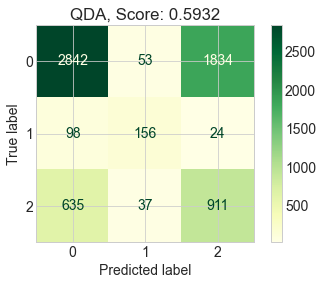

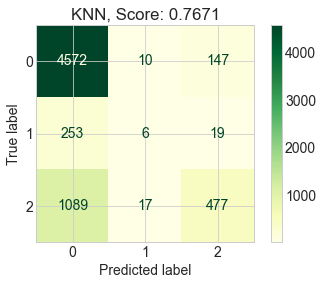

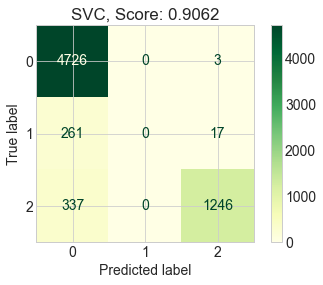

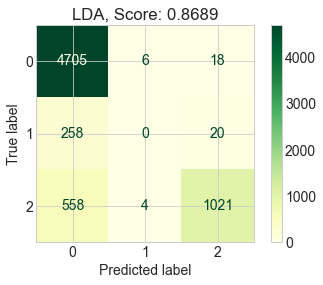

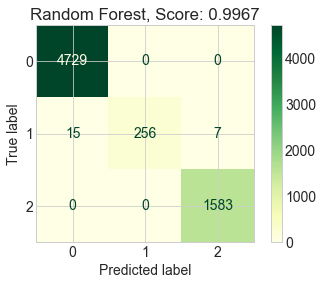

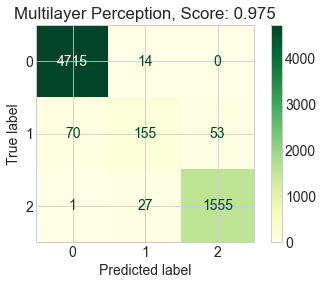

In [278]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(random_state=0)
randomForest = RandomForestClassifier(random_state=0) #adding state 0 we achieve score 1.0 with 1 we get 0.99
algonames = ["QDA", "KNN", "SVC", "LDA", "Random Forest", "Multilayer Perception"]
counter = 0
knn = KNeighborsClassifier()
svc = SVC(random_state=0)
lda = LDA(solver="lsqr")
qda = QDA()
options= [qda, knn, svc, lda, randomForest, mlp]
for i in options:
    i.fit(X_train,y_train)
    ypred=i.predict(X_test)
    result = confusion_matrix(y_test, ypred)
    print("Confusion Matrix:")
    print(result)
    result1 = classification_report(y_test, ypred)
    print("Classification Report:",)
    print (result1)
    result2 = accuracy_score(y_test,ypred)
    print("Accuracy:",result2)

    disp = ConfusionMatrixDisplay(confusion_matrix=result,
                                  display_labels=i.classes_)
    disp.plot(cmap="YlGn")
    disp.ax_.set_title(algonames[counter]+", Score: "+str(round(result2, 4)))
    counter+=1

    #plot_confusion_matrix(i, X_test, y_test, cmap="YlGn", normalize="pred")

In [279]:
"""plt.scatter(data[price], data.Revenue, marker=".", label="Sample")
plt.plot(data[price], reg.fittedvalues, c="k", label="Fit")
plt.ylabel("Revenue")
plt.xlabel("Price in %")
plt.legend()"""

'plt.scatter(data[price], data.Revenue, marker=".", label="Sample")\nplt.plot(data[price], reg.fittedvalues, c="k", label="Fit")\nplt.ylabel("Revenue")\nplt.xlabel("Price in %")\nplt.legend()'

In [280]:
#https://www.geeksforgeeks.org/logistic-regression-using-statsmodels/
